In [1]:
import os
import json

foa_path = "../arxiv/logs/gameof24/gpt4/test-set_9agents_9steps_1k_120.0origin_0.5backtrack_linear_filtered-resampling.json"

tot_path = "../arxiv/benchmarks/gameof24/GPT4/ToT/gpt-4-0613_0.7_propose1_value3_greedy5_start900_end1000.json"

with open(foa_path, "r") as f:
    foa = json.load(f)
foa_info = foa.pop("Info")

with open(tot_path, "r") as f:
    tot = json.load(f)
tot = {str(i+900): puzzle for i, puzzle in enumerate(tot)}

In [2]:
# Find puzzles for which FoA succeeded and ToT has not
puzzles = []
for puzzle_id in range(900, 1000):
    foa_puzzle = foa[str(puzzle_id)]
    tot_puzzle = tot[str(puzzle_id)]
    
    if {"r":1} in foa_puzzle["Verifications"] and {"r":1} not in tot_puzzle["infos"]:
        puzzles.append(puzzle_id)

# Save the examples in their own files
for puzzle_id in puzzles:
    
    foa_example = foa[str(puzzle_id)]
    tot_example = tot[str(puzzle_id)]

    folder_path = f"{puzzle_id}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    foa_example_path = f"{folder_path}/foa_example.json"
    tot_example_path = f"{folder_path}/tot_example.json"

    with open(foa_example_path, "w+") as f:
        json.dump(foa_example, f, indent=4)

    with open(tot_example_path, "w") as f:
        json.dump(tot_example, f, indent=4)

In [3]:
# Somewhat of a tool that I used to browse through the example. Can change puzzle_id to see different examples and step to set the step of the tot example
puzzle_id = 901
foa_example = foa[str(puzzle_id)]
tot_example = tot[str(puzzle_id)]

for i, v in enumerate(foa_example["Verifications"]):
    if v == {"r":1}:
        print(list(foa_example[f"Agent {i}"].values())[-1])

step = 1
print(f"New ys at step {step}")
for y, value in zip(tot_example["steps"][step]["new_ys"], tot_example["steps"][step]["values"]):
    print("\t", y.replace("\n", " ").strip(), " - ", value)

print(f"Selected ys at step {step}")
for y in tot_example["steps"][step]["select_new_ys"]:
    print("\t", y.replace("\n", " ").strip())

{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 - 1 = 6 (left: 4 6) -> 4 * 6 = 24 (left: 24) -> Answer: 4 * (7 - (2 - 1)) = 24'}
{'Step': '2 - 1 = 1 (left: 1 4 7) -> 7 -

Problems from ToT perspective:
- 901 : Correct action found and selected in step 0. No correct action founf in step 1.
- 904 : No correct actions from the very first step. No way for the algorithm to backtrack and retry.
- 913 : Correct action found and selected in step 0. Correct solution found in step 1 too but misevaluated and rejected.
- 921 : No correct actions from the very first step. No way for the algorithm to backtrack and retry.
- 942 : Correct action found in step 0 but immediately disregarded. No way for the algorithm to backtrack and retry.
- 944 : Correct action found and selected in step 0,1,3. However only 1 y with the correct actionos up to the final step. In final step, the LLM messes up the maths and the solution is fails.
- 956 : Correct action found in step 0 but immediately disregarded. No way for the algorithm to backtrack and retry.
- 965 : No correct actions from the very first step. No way for the algorithm to backtrack and retry.
- 972 : Correct action found and selected in step 0,1,3. However only 1 y with the correct actionos up to the final step. In final step, the LLM messes up the maths and the solution is fails.
- 986 : No correct actions from the very first step. No way for the algorithm to backtrack and retry.

Most common errors:
- The states are unique and are all given the same amount of resources. Therefore, a good state has the same chance to win as a bad state. That is, the "agents" or more correctly the path that moves correctly has no space for mistakes. It either gets the result in once or it doens't.
- There is no mechanism to help when all states are bad (ie. there's no way to get a solution from them no matter what).

---
# Visualization (still in progress)
Still not finished, just keeping here in case it works out. The idea is to keep it like this, reduce the noise and highlight the correct paths by highlighting correct nodes/edges.

In [4]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt



def find_parent(child, possible_parents):
    for parent in possible_parents:
        if child.startswith(parent):
            return parent
    assert False
        
def format_y(node, step=None):
    return node.replace(":",";;")

def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [8]:
init = tot_example["steps"][0]["x"]
tot_graph = nx.Graph()
tot_graph.add_node(init, puzzle=init, height=0, fixedsize=True)

nodes_with_labels = {}
# ToT Step 1
parents = []
for new_y in tot_example["steps"][0]["new_ys"]:
    parents.append(new_y)
    #new_y = format_y(new_y,0)
    tot_graph.add_node(new_y)
    tot_graph.add_edge(init, new_y)

old_parents = parents
for i in range(1):
    parents=old_parents
    for step in range(1,4):
        new_parents = []
        for new_y in tot_example["steps"][step]["new_ys"]:
            new_parents.append(new_y)
            parent = find_parent(new_y, parents)
            #new_y = format_y(new_y, step)
            tot_graph.add_node(new_y)
            tot_graph.add_edge(parent, new_y)
            if new_y in tot_example["steps"][step]["select_new_ys"]:
                nodes_with_labels.update({new_y: new_y})
        parents = new_parents

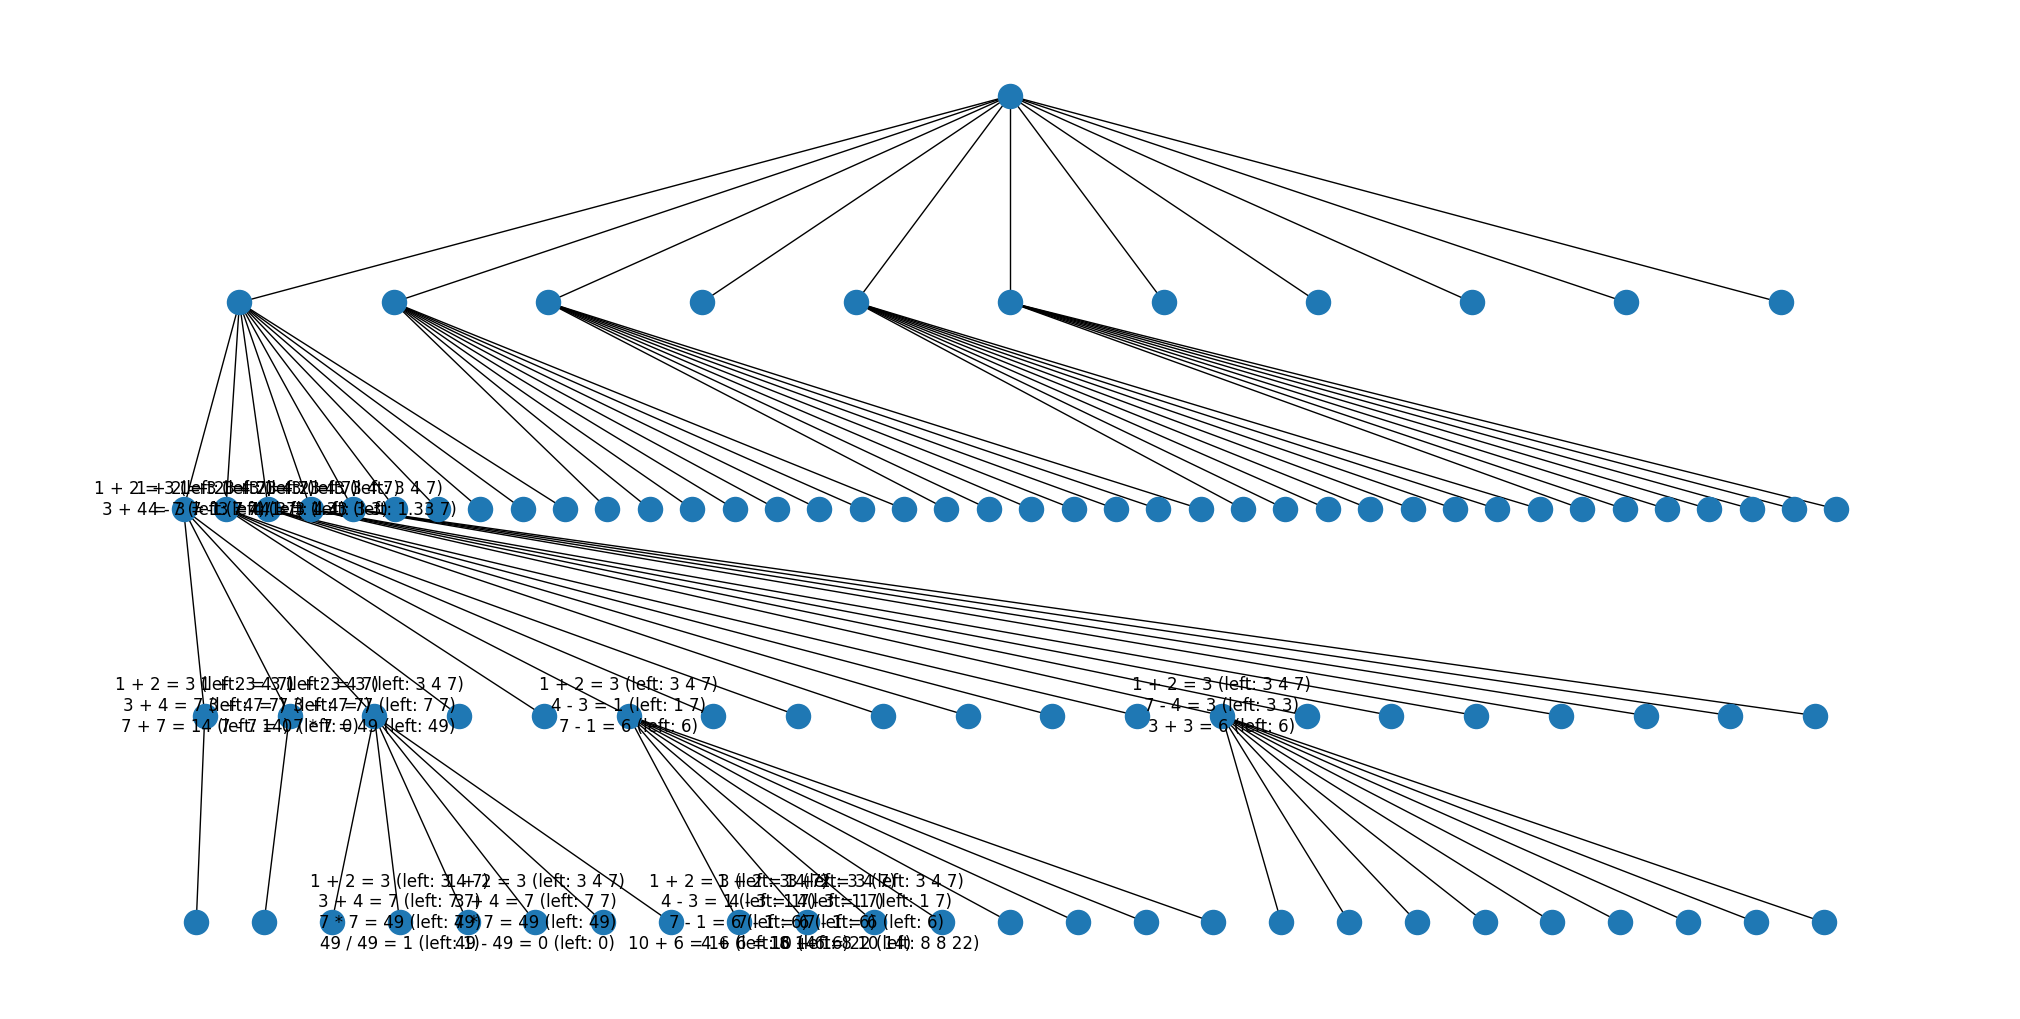

In [9]:
pos = hierarchy_pos(tot_graph, init)

figure = plt.figure(figsize=(20, 10))
nx.draw(tot_graph, pos, labels=nodes_with_labels)